In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, accuracy_score, classification_report, r2_score as r2
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier
import torch
import keras
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from sklearn.pipeline import make_pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [4]:
#Importing Data
df = pd.read_csv('data/address_data.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [5]:
# Feature Engineering

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

scaled_train_x_list = []
scaled_test_x_list = []
train_y_list = []
test_y_list = []

for i in range(10):
    # Log for Skewed Data
    train_df_new = train_list[i].drop(columns=['Address', 'FLAG'])
    test_df_new = test_list[i].drop(columns=['Address', 'FLAG'])

    for c in columns:
        train_df_new[c] = train_df_new[c].apply(lambda x: np.log(x) if x > 0 else 0)
        test_df_new[c] = test_df_new[c].apply(lambda x: np.log(x) if x > 0 else 0)

    # Scaling
    train_df_new = scaler.fit_transform(train_df_new)
    test_df_new = scaler.transform(test_df_new)

    scaled_train_x_list.append(train_df_new)
    scaled_test_x_list.append(test_df_new)
    train_y_list.append(train_list[i][['FLAG']])
    test_y_list.append(test_list[i][['FLAG']])

#np.isnan(scaled_train_x_list[0])

NameError: name 'train_list' is not defined

In [ ]:
torch.cuda.is_available()

False

tabnet Optimization: Source - https://arxiv.org/pdf/1908.07442.pdf
Nd and Na are chosen from {8, 16, 24, 32, 64, 128}
Nsteps is chosen from {3, 4, 5, 6, 7, 8, 9, 10}, 
γ is chosen from {1.0, 1.2, 1.5, 2.0}, 
λsparse is chosen from {0, 0.000001, 0.0001, 0.001, 0.01, 0.1}, 
B is chosen from {256, 512, 1024, 2048, 4096, 8192, 16384, 32768}, 
BV is chosen from {256, 512, 1024, 2048, 4096}, 
the learning rate is chosen from {0.005, 0.01.0.02, 0.025}, 
the decay rate is chosen from {0.4, 0.8, 0.9, 0.95},
the decay iterations is chosen from {0.5k, 2k, 8k, 10k, 20k}, 
and mB is chosen from {0.6, 0.7, 0.8, 0.9, 0.95, 0.98}. 

If the model size is not
under the desired cutoff, we decrease the value to satisfy
the size constraint. For all the comparison models, we run a
hyperparameter tuning with the same number of search steps.

In [ ]:
tabnet_params = {
    "verbose": 0,
    "cat_emb_dim": 1,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2),
    "scheduler_params": {"step_size":50, # how to use learning rate scheduler
                        "gamma":0.9},
    "scheduler_fn": torch.optim.lr_scheduler.StepLR,
    "mask_type":'entmax',
    }

xgb_params = {
    'max_depth':8,
    'learning_rate':0.1,
    'n_estimators':1000,
    'verbosity':0,
    'objective':'binary:logistic',
    'booster':'gbtree',
    'gamma':0,
    'min_child_weight':1,
    'max_delta_step':0,
    'subsample':0.7,
    'colsample_bytree':1,
    'colsample_bylevel':1,
    'colsample_bynode':1,
    'reg_alpha':0,
    'reg_lambda':1,
    'scale_pos_weight':1,
    'base_score':0.5,
}

# define dataset
X_train, y_train = scaled_train_x_list[0], train_y_list[0].values.ravel()
X_test, y_test = scaled_test_x_list[0], test_y_list[0].values.ravel()

input_dim = X_train.shape[1]
# number of hidden nodes
H = 40
# num of epochs
num_epochs = 100
# num_layers
num_layers = 5
# activation function
activation_function = 'relu'

def create_mlp_model():
    model_n = Sequential()
    model_n.add(layers.Dense(H, input_shape=(input_dim, ), activation= activation_function))
    for _ in range(num_layers - 1):
        model_n.add(layers.Dense(H, activation= activation_function))
    model_n.add(layers.Dense(1, activation='sigmoid'))
    model_n.compile(loss='mean_squared_error', optimizer='adam')
    return model_n

Kmodel = KerasClassifier(build_fn=create_mlp_model, verbose=0)
pipe = Pipeline([
    ('model', Kmodel),
])

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    tabnet = TabNetClassifier(
                verbose = 0,
                optimizer_fn=torch.optim.Adam,
                optimizer_params=dict(lr=2e-2),
                scheduler_params={"step_size":10, # how to use learning rate scheduler
                                  "gamma":0.9},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                mask_type='sparsemax' # This will be overwritten if using pretrain model
            )
    models['tabnet'] = tabnet
    models['svm'] = svm.SVC()
    models['xgboost'] = XGBClassifier(**xgb_params)
    models['mlp'] = pipe
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)#, error_score='raise')
    return scores
 
# define dataset
X, y = scaled_train_x_list[0], train_y_list[0].values.ravel()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
'''
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()
'''

"\nresults, names = list(), list()\nfor name, model in models.items():\n    scores = evaluate_model(model, X, y)\n    results.append(scores)\n    names.append(name)\n    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))\n# plot model performance for comparison\nplt.boxplot(results, labels=names, showmeans=True)\nplt.show()\n"

In [ ]:
def get_stacking():
    # define the base models
    level0 = list()
    for key,value in get_models().items():
        level0.append([key,value])
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=10)
    return model

def get_models2():
    models = dict()
    for key,value in get_models().items():
        models[key] = value
    models['stacking'] = get_stacking()
    return models

models2 = get_models2()

In [ ]:
#Not quite sure why this does not work - Alternative manual implementation below
for name, model in models2.items():
    model = model.fit(X_train, y_train)
    scores = model.score(X_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_tabnet\abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


AttributeError: 'NoneType' object has no attribute 'score'

In [ ]:
#Seperate cell since tabnet throwing the error
clf = TabNetClassifier(
    **tabnet_params)

clf.fit(X_train=X_train, y_train=y_train)

predictions = clf.predict(X_test)
tabnet_acc = accuracy_score(y_test, predictions)

C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_tabnet\abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [ ]:
#Rest of the models
clf2 = svm.SVC()
clf2.fit(X_train, y_train)
predictions = clf2.predict(X_test)

svm_acc = accuracy_score(y_test, predictions)

clf3 = XGBClassifier(**xgb_params)
clf3.fit(X_train, y_train)
predictions = clf3.predict(X_test)

xgb_acc = accuracy_score(y_test, predictions)

clf4 = pipe
clf4.fit(X_train, y_train)
predictions = clf4.predict(X_test)

mlp_acc = accuracy_score(y_test, predictions)
                         
#debugging stacking error
def get_stacking():
    # define the base models
    level0 = list()
    for key,value in get_models().items():
        try:
            value._estimator_type = 'classifier'
        except AttributeError:
            pass
        finally:
            level0.append([key,value])
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=10)
    return model

clf5 = get_stacking().fit(X_train, y_train)
predictions = clf5.predict(X_test)

stack_acc = accuracy_score(y_test, predictions)
results = [tabnet_acc, svm_acc, xgb_acc, mlp_acc, stack_acc]
names = []
for name, model in models2.items():
    names.append(name)

C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_tabnet\abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_

In [ ]:
print(results)
print(names)

[0.9447619047619048, 0.9161904761904762, 0.9580952380952381, 0.866031746031746, 0.96]
['tabnet', 'svm', 'xgboost', 'mlp', 'stacking']


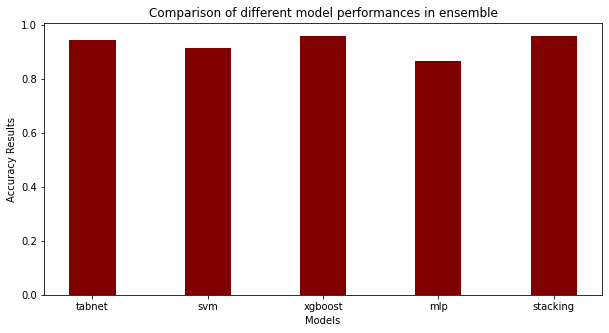

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(names, results, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy Results")
plt.title("Comparison of different model performances in ensemble")
plt.show()

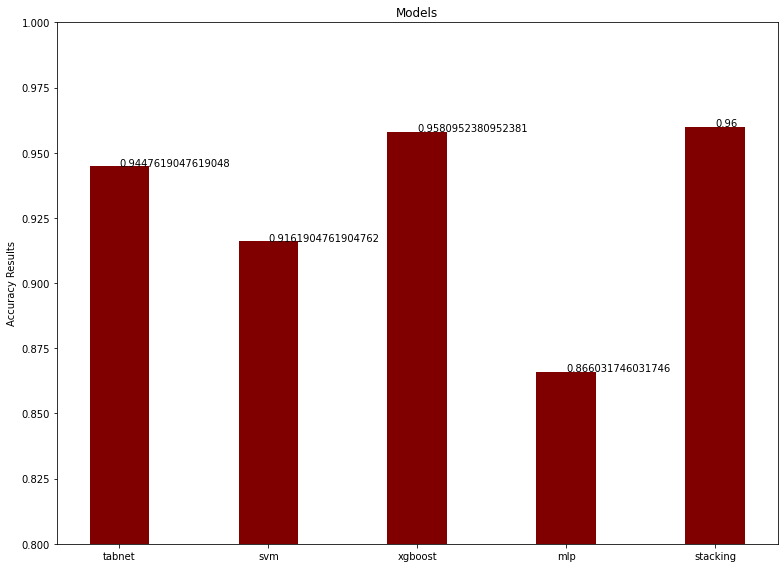

In [ ]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fig, ax = plt.subplots()

ax.set_ylabel("Accuracy Results")
ax.set_title("Models")
plt.ylim(0.8,1)
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

addlabels(names, results)
plt.bar(names, results, color ='maroon',
        width = 0.4)

plt.show()